In [1]:
import os
import torch
import shutil
import numpy as np
import re 

from PIL import Image
from tqdm import tqdm
from urllib.request import urlretrieve
import json

from pytransform3d.transform_manager import TransformManager

class RoboCupDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train", transform=None):

        assert mode in {"train", "valid", "test", "two_sequence", "three_sequence"}

        self.root = root
        self.mode = mode
        self.transform = transform

        self.files_directory = self.root

        self.filenames = self._read_split()  # read train/valid/test splits
        
        self.classes = {0:0,  40:1, 88:2, 112:3, 136:4, 184:5, 208:6, 232:7}
        
        #Saving Camera Matrix K and its inverse
        if self.mode ==  "train" or self.mode == "valid": 
            filename = self.filenames[0]
        elif self.mode == "two_sequence" or self.mode == "three_sequence":
            filename = self.filenames[0][0]
        print ("filename ", filename)
        file_path = os.path.join(self.files_directory, filename)

        with h5py.File(file_path, 'r') as data:
            transformation_matrix = json.loads(np.array(data['camera_pose']).item().decode()) 
            
        self.K = np.array(transformation_matrix['cam_K']).reshape(3,3)
        self.Kinv= np.linalg.inv(self.K)

        

    def __len__(self):
        return len(self.filenames)

    
    @staticmethod
    def _give_rotation_translation(old_transformation_matrix,
                                 new_transformation_matrix):
        R = np.array(old_transformation_matrix['cam_R_w2c']).reshape(3,3)
        T = np.array(old_transformation_matrix['cam_t_w2c']).reshape(3,1)
        old_pose = np.hstack((R,T))
        old_pose = np.vstack((old_pose,[0., 0., 0., 1.]))
        
        R = np.array(new_transformation_matrix['cam_R_w2c']).reshape(3,3)
        T = np.array(new_transformation_matrix['cam_t_w2c']).reshape(3,1)
        new_pose = np.hstack((R,T))
        new_pose = np.vstack((new_pose,[0., 0., 0., 1.]))
        
        tm = TransformManager()
        tm.add_transform("world", "old_pose", old_pose)
        tm.add_transform("world", "new_pose", new_pose)
        old2new = tm.get_transform("old_pose", "new_pose")
        R = old2new[:3,:3]
        T = old2new[:3,3].reshape(3,1)
        return R, T
    
    def __getitem__(self, idx):

        if self.mode == "train" or self.mode == "valid": 
            filename = self.filenames[idx]
            file_path = os.path.join(self.files_directory, filename)

            with h5py.File(file_path, 'r') as data: 
                image = np.array(data['colors'])
                mask = np.array(data['class_segmaps'])


            #trimap = np.array(Image.open(mask_path))
            mask = self._preprocess_mask(mask)

            sample = dict(image=image, mask=mask)
            if self.transform is not None:
                sample = self.transform(**sample)
        elif self.mode == "two_sequence" or self.mode == "three_sequence":
            #For sequence
            # send all the n images
            # only last frame maske
            # all the poses 
            seq_filenames = self.filenames[idx]
            
            images = []
            maskes = []
            depths = []
            transformation_matrices = []
            for filename in seq_filenames:
                file_path = os.path.join(self.files_directory, filename)

                with h5py.File(file_path, 'r') as data: 
                    images.append(np.array(data['colors']))
                    mask = np.array(data['class_segmaps'])
                    depths.append(np.array(data['depth']))
                    transformation_matrices.append(json.loads(np.array(data['camera_pose']).item().decode()))

                #trimap = np.array(Image.open(mask_path))
                maskes.append( self._preprocess_mask(mask))

            sample = dict(image=images, mask=maskes, transformation_matrix=transformation_matrices)
            
            if self.mode == "two_sequence":
                rotation_old_to_new_camera_frame, \
                translation_old_to_new_camera_frame = self._give_rotation_translation(transformation_matrices[0], 
                                                                                  transformation_matrices[1])
                sample = dict(image0 = images[0],
                              depth0 = depths[0],
                              image1 = images[1], 
                              mask0 = maskes[0], 
                              mask1 = maskes[1], 
                              rotation_old_to_new_camera_frame = rotation_old_to_new_camera_frame,
                              translation_old_to_new_camera_frame = translation_old_to_new_camera_frame)
            elif self.mode == "three_sequence":
                raise NotImplemented

        else:
            raise NotImplementedError("check mode variable while instantiating")

        return sample

    @staticmethod
    def _preprocess_mask(mask):
        classes = {0:0,  40:1, 88:2, 112:3, 136:4, 184:5, 208:6, 232:7}
        mask = mask.astype(np.float32)
        #Remove this and do it in before loading data and save as h5p5
        for c in classes:
            mask[mask==c] = classes[c]

        return mask
    
    
    
    
    def _read_split(self):
        def _atoi(text):
            return int(text) if text.isdigit() else text

        def _natural_keys(text):
            '''
            alist.sort(key=natural_keys) sorts in human order
            http://nedbatchelder.com/blog/200712/human_sorting.html
            (See Toothy's implementation in the comments)
            '''
            return [ _atoi(c) for c in  text.split('.') ]

        
        filenames = [f for f in os.listdir(self.files_directory) if os.path.isfile(os.path.join(self.files_directory, f))]
        
        if self.mode == "train":  # 90% for train
            filenames = [x for i, x in enumerate(filenames) if i % 10 != 0]
        elif self.mode == "valid":  # 10% for validation
            filenames = [x for i, x in enumerate(filenames) if i % 10 == 0]
        elif self.mode == "three_sequence": 
            #Sorting files as per the numbering
            # Assumption that files are numbered '0.hdf5', '1.hdf5', '10.hdf5', '
            # Assumption there is 3 images in sequnce starting from 0 
            filenames.sort(key=_natural_keys)
            
            filenames = [[filenames[i+n] for n in range(3)] 
                         for i, x in enumerate(filenames) if i % 3 == 0]
        elif self.mode == "two_sequence": 
            #Sorting files as per the numbering
            # Assumption that files are numbered '0.hdf5', '1.hdf5', '10.hdf5', '
            filenames.sort(key=_natural_keys)
            
            # 3 camera poses can be divided into 2 frames each
            # for example 1 - 2- 3 images
            # can be divided in to [1,2] and [2,3] sequence
            filenames = [[filenames[i+j+n] for n in range(2)] 
                         for i, x in enumerate(filenames) if i % 3 == 0
                         for j in range(2)] 
                        
            print( filenames)
        return filenames


class SimpleRoboCupDataset(RoboCupDataset):
    def __getitem__(self, *args, **kwargs):

        sample = super().__getitem__(*args, **kwargs)

        # resize images
        image = np.array(Image.fromarray(samples["image"]).resize((256, 256), Image.LINEAR))
        mask = np.array(Image.fromarray(samples["mask"]).resize((256, 256), Image.NEAREST))

        # convert to other format HWC -> CHW
        samples["image"]= np.moveaxis(image, -1, 0)
        samples["mask"] = np.expand_dims(mask, 0)

        return sample



In [305]:

class SequenceRoboCupDataset(RoboCupDataset):
    def __getitem__(self, *args, **kwargs):

        sample = super().__getitem__(*args, **kwargs)
        
        
        # resize images
        image0 = np.array(Image.fromarray(sample["image0"]).resize((512, 512), Image.LINEAR))
        image1 = np.array(Image.fromarray(sample["image1"]).resize((512, 512), Image.LINEAR))
        mask0 = np.array(Image.fromarray(sample["mask0"]).resize((512, 512), Image.NEAREST))
        mask1 = np.array(Image.fromarray(sample["mask1"]).resize((512, 512), Image.NEAREST))


        # convert to other format HWC -> CHW
        sample["image0"] = np.moveaxis(image0, -1, 0)
        sample["image1"] = np.moveaxis(image1, -1, 0)
        sample["mask0"] = np.expand_dims(mask0, 0)
        sample["mask1"] = np.expand_dims(mask1, 0)

        return sample


In [306]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import h5py

from pprint import pprint
from torch.utils.data import DataLoader

In [307]:
#root = '../learning_blenerproc/images_robocup'
root = '../learning_blenerproc/images_pose_robocup/'

train_dataset = SequenceRoboCupDataset(root, "two_sequence")


[['0000.hdf5', '0001.hdf5'], ['0001.hdf5', '0002.hdf5'], ['0003.hdf5', '0004.hdf5'], ['0004.hdf5', '0005.hdf5'], ['0006.hdf5', '0007.hdf5'], ['0007.hdf5', '0008.hdf5'], ['0009.hdf5', '0010.hdf5'], ['0010.hdf5', '0011.hdf5'], ['0012.hdf5', '0013.hdf5'], ['0013.hdf5', '0014.hdf5'], ['0015.hdf5', '0016.hdf5'], ['0016.hdf5', '0017.hdf5'], ['0018.hdf5', '0019.hdf5'], ['0019.hdf5', '0020.hdf5'], ['0021.hdf5', '0022.hdf5'], ['0022.hdf5', '0023.hdf5'], ['0024.hdf5', '0025.hdf5'], ['0025.hdf5', '0026.hdf5'], ['0027.hdf5', '0028.hdf5'], ['0028.hdf5', '0029.hdf5'], ['0030.hdf5', '0031.hdf5'], ['0031.hdf5', '0032.hdf5'], ['0033.hdf5', '0034.hdf5'], ['0034.hdf5', '0035.hdf5'], ['0036.hdf5', '0037.hdf5'], ['0037.hdf5', '0038.hdf5'], ['0039.hdf5', '0040.hdf5'], ['0040.hdf5', '0041.hdf5'], ['0042.hdf5', '0043.hdf5'], ['0043.hdf5', '0044.hdf5'], ['0045.hdf5', '0046.hdf5'], ['0046.hdf5', '0047.hdf5'], ['0048.hdf5', '0049.hdf5'], ['0049.hdf5', '0050.hdf5'], ['0051.hdf5', '0052.hdf5'], ['0052.hdf5', '0053

In [308]:
train_dataset.K

array([[711.11127387,   0.        , 255.5       ],
       [  0.        , 711.11127387, 255.5       ],
       [  0.        ,   0.        ,   1.        ]])

In [309]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=int(16/2))


In [310]:
batch = next(iter(train_dataloader))


In [311]:
batch['depth0'].shape

torch.Size([10, 512, 512])

flateneded Depth  torch.Size([10, 1, 262144])
Translatio :  torch.Size([10, 3, 1])
tensor([[-0.0023],
        [ 0.0006],
        [-0.2188]], dtype=torch.float64)
Rotation :  torch.Size([10, 3, 3]) tensor([[ 1.0000e+00, -1.3878e-17,  2.7756e-17],
        [-1.3878e-17,  1.0000e+00,  0.0000e+00],
        [ 2.7756e-17,  0.0000e+00,  1.0000e+00]], dtype=torch.float64)


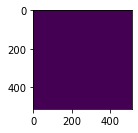

In [545]:
flattened_depth = torch.flatten(batch['depth0'], start_dim=1)
flattened_depth = torch.unsqueeze(flattened_depth, dim=1)
print ("flateneded Depth ", flattened_depth.shape)
T = batch['translation_old_to_new_camera_frame']
print ("Translatio : ", T.shape,)
print (T[0])
R = batch['rotation_old_to_new_camera_frame'].double()
print ("Rotation : ", R.shape,  R[0])

height = 512
width = 512
x = torch.arange(height)
y = torch.arange(width)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
grid_x = torch.flatten(grid_x, start_dim=0)
grid_y = torch.flatten(grid_y, start_dim=0)

## Stacking to make the matrix 3 x points
pts = torch.vstack((grid_x, grid_y, torch.ones_like(grid_y)))
pts.shape


K = torch.tensor(train_dataset.K)
Kinv = torch.tensor(train_dataset.Kinv)

Kinv = Kinv.float()
K = K.float()
R = R.float()
pts = pts.float()
flattened_depth = flattened_depth.float()
T = T.float()

first_part = torch.matmul(torch.matmul(torch.matmul(K, R), Kinv), pts) 
second_part = torch.matmul(K,torch.div(T, flattened_depth))
ggg = torch.matmul(torch.matmul(torch.matmul(K, R), Kinv), pts) + torch.matmul(K,torch.div(T, flattened_depth))
ggg.shape

small_g = ggg[:,2,:]
small_g = small_g.unsqueeze(1)
small_g.shape

new_pts_tensor = torch.div(ggg, small_g)
new_pts_tensor.shape

new_pts_tensor_clamped = torch.clamp(new_pts_tensor, min=0, max=511).type(torch.LongTensor) # imagesize is 512 ,  1 less than 512
new_pts_tensor_clamped

channel = 1
dimension = 1
only_first_index_for_gather = new_pts_tensor_clamped[:,channel,:]
only_first_index_for_gather.shape


flattened_mask = torch.flatten(batch['mask0'], start_dim=1)
flattened_mask.shape
transposed_mask = torch.gather(flattened_mask, dimension, only_first_index_for_gather)
tmask = transposed_mask[0].reshape(512,512)

ax = plt.subplot(1, 3, 3)
plt.imshow(tmask)


torch.Size([262144])


torch.Size([3, 262144])

torch.Size([10, 3, 262144])

torch.Size([10, 1, 262144])

In [472]:
new_pts_tensor = torch.div(ggg, small_g)
new_pts_tensor.shape

torch.Size([10, 3, 262144])

In [473]:
new_pts_tensor = torch.clamp(new_pts, min=0, max=511).type(torch.LongTensor) # imagesize is 512 ,  1 less than 512


In [444]:
flattened_mask[1, 257]

tensor(0.)

In [445]:
only_first_index_for_gather = new_pts_tensor[:,0,:]
only_first_index_for_gather = only_first_index_for_gather.type(torch.LongTensor)
only_first_index_for_gather.shape

torch.Size([10, 262144])

In [446]:
print (batch['mask0'].shape)
flattened_mask = torch.flatten(batch['mask0'], start_dim=1)
flattened_mask.shape

torch.Size([10, 1, 512, 512])


torch.Size([10, 262144])

In [447]:
transposed_mask = torch.gather(flattened_mask, 1, only_first_index_for_gather)
transposed_mask.shape

torch.Size([10, 262144])

In [448]:
tmask = transposed_mask[0].reshape(512,512)

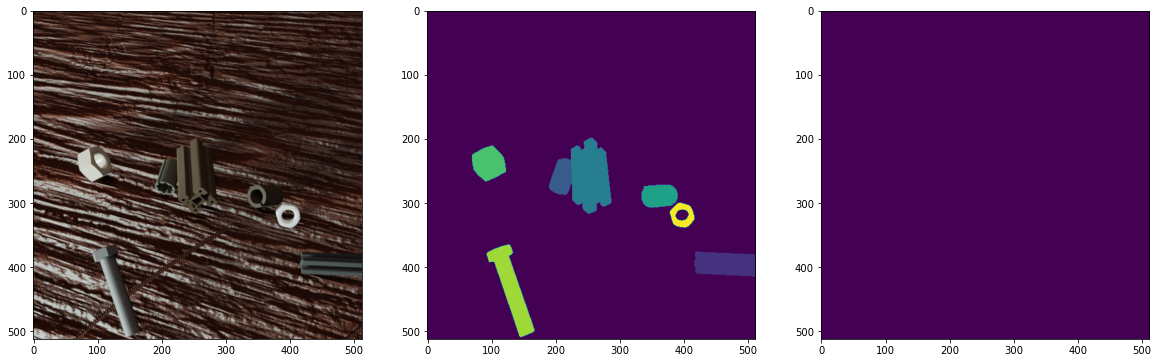

In [449]:
image = batch['image1'][0].detach().numpy()
image = np.transpose(image,(1,2,0))
mask = batch['mask1'][0].detach().numpy()
mask = np.transpose(mask,(1,2,0))
tmask = tmask.detach().numpy()
#plotting
plt.figure(figsize=(20, 10))
ax = plt.subplot(1, 3, 1)
plt.imshow(image)
ax = plt.subplot(1, 3, 2)
plt.imshow(mask)
ax = plt.subplot(1, 3, 3)
plt.imshow(tmask)


# TODO 

* Check with 1 example the output doesnot match expected

* Use torch gather 
    - Where ?



In [96]:
# batched matrix x broadcasted vector
K = torch.randn(3, 3)
R = torch.randn(10,3,3)
Kinv = torch.randn(3, 3)
pts = torch.randn(3, 262144)
torch.matmul(torch.matmul(torch.matmul(K, R), Kinv), pts).size()

torch.Size([10, 3, 262144])

In [68]:
T = torch.randn(3, 512)
torch.matmul(K,T).size()

torch.Size([10, 3, 512])

In [69]:
gggg = torch.matmul(torch.matmul(torch.matmul(K, R), Kinv), pts) + torch.matmul(K,T)
gggg.size()

torch.Size([10, 3, 512])

## Old code 

In [3]:
root = '../learning_blenerproc/images_robocup'
# init train, val, test sets
train_dataset = SimpleRoboCupDataset(root, "train")
valid_dataset = SimpleRoboCupDataset(root, "valid")

# It is a good practice to check datasets don`t intersects with each other
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")

n_cpu = os.cpu_count()
n_batch_size = 32
print (" CPU ", n_cpu)
train_dataloader = DataLoader(train_dataset, batch_size=n_batch_size, shuffle=True, num_workers=int(n_cpu/2))
valid_dataloader = DataLoader(valid_dataset, batch_size=n_batch_size, shuffle=False, num_workers=int(n_cpu/2))


Train size: 297
Valid size: 33
 CPU  16


-----

# Learning Gather

We want to take a tensor [batch_size, 3, 9] and have another tensor with places [batch_size, 3, 9] 



In [2]:
height = 4
width = 4
x = torch.arange(height)
y = torch.arange(width)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
grid_x = torch.flatten(grid_x, start_dim=0)
grid_y = torch.flatten(grid_y, start_dim=0)

print (grid_x.shape)
## Stacking to make the matrix 3 x points
pts = torch.vstack((grid_x, grid_y, torch.ones_like(grid_y)))
print (pts.shape)
print (pts)
#pts = pts.unsqueeze(0)
print (pts.shape)
print (pts)



torch.Size([16])
torch.Size([3, 16])
tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
torch.Size([3, 16])
tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [7]:
image = torch.randn(1, 3, 4, 4)
#image = image.unflatten(1, [3, 3])
#image = image.unflatten(1, [3, 3])
image = torch.flatten(image, start_dim=2)
image.shape

torch.Size([1, 3, 16])

In [8]:
#Use pts and gather to 
# If dim=batch + 0 then use first row of pts 
# if dim=batch + 1 then use second row of pts 
# use only 1 row of pts is enough 
index = pts[1,:]
print (index)
index = index.unsqueeze(0)
print (index.shape)
#index = index.unflatten(1, 16)
#index = index.unsqueeze(1)

print (image.shape, index.shape)
index = index.repeat(1, 3, 1)
print (image)
print (image.shape, index.shape)

#torch.gather(image, 1, index)


output = torch.gather(image, 2, index)
output
print (output)

tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])
torch.Size([1, 16])
torch.Size([1, 3, 16]) torch.Size([1, 16])
tensor([[[ 1.4014,  0.5981,  0.5345,  0.4809, -0.3187,  3.1745,  0.1748,
           1.2645,  0.6793, -1.0629,  0.3888, -2.0504,  0.1627, -0.0348,
           0.0896, -0.4427],
         [-0.5192, -0.5606, -1.3807, -0.7929,  0.4230,  0.8288, -0.0674,
           1.5951,  0.1044,  0.7687, -0.9648, -0.6379, -0.8160, -0.6301,
           0.3300,  0.8841],
         [ 0.1443,  0.8693, -1.7747, -0.4313, -0.8441,  0.7152,  0.5675,
           0.7442, -0.3205, -1.7977, -2.3152,  0.5985, -0.8928, -0.6209,
           1.3666, -0.1087]]])
torch.Size([1, 3, 16]) torch.Size([1, 3, 16])
tensor([[[ 1.4014,  0.5981,  0.5345,  0.4809,  1.4014,  0.5981,  0.5345,
           0.4809,  1.4014,  0.5981,  0.5345,  0.4809,  1.4014,  0.5981,
           0.5345,  0.4809],
         [-0.5192, -0.5606, -1.3807, -0.7929, -0.5192, -0.5606, -1.3807,
          -0.7929, -0.5192, -0.5606, -1.3807, -0.7929, -0.5

In [133]:
image.unflatten(2, [3, 3]).shape

torch.Size([1, 3, 3, 3])

In [154]:
dim = 0
inn = torch.tensor([[10, 11, 12], [13, 14, 15], [16, 17, 18]])
index = torch.tensor([[0, 1, 2], [1, 2, 0]])
print (inn.shape , index.shape)
output = torch.gather(inn, dim, index)
output

torch.Size([3, 3]) torch.Size([2, 3])


tensor([[10, 14, 18],
        [13, 17, 12]])

In [156]:
index = torch.tensor([[0, 0, 0], [1, 1, 1], [2, 2 ,2]])
torch.gather(inn, dim, index)

tensor([[10, 11, 12],
        [13, 14, 15],
        [16, 17, 18]])

In [157]:
dim = 1
inn = torch.tensor([[10, 11, 12], [13, 14, 15], [16, 17, 18]])
print (inn.shape)
inn = inn.unsqueeze(0)
print (inn.shape)

index = torch.tensor([[0, 1, 2], [1, 2, 0]])
index = torch.tensor([[[0, 0, 0], [1, 1, 1], [2, 2 ,2]]])
print (inn.shape , index.shape)

output = torch.gather(inn, dim, index)
output

torch.Size([3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3]) torch.Size([1, 3, 3])


tensor([[[10, 11, 12],
         [13, 14, 15],
         [16, 17, 18]]])

In [189]:
dim = 1
inn = torch.tensor([[10, 11, 12], [13, 14, 15], [16, 17, 18]])
print (inn.shape)
inn = inn.unsqueeze(0)
print (inn.shape)

index = torch.tensor([[[0, 0],[0, 1]]])
print (index.shape)
output = torch.gather(inn, dim, index)
output

torch.Size([3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 2, 2])


tensor([[[10, 11],
         [10, 14]]])

In [151]:
index.shape

torch.Size([1, 3, 3])

# Previous working code for comparions 

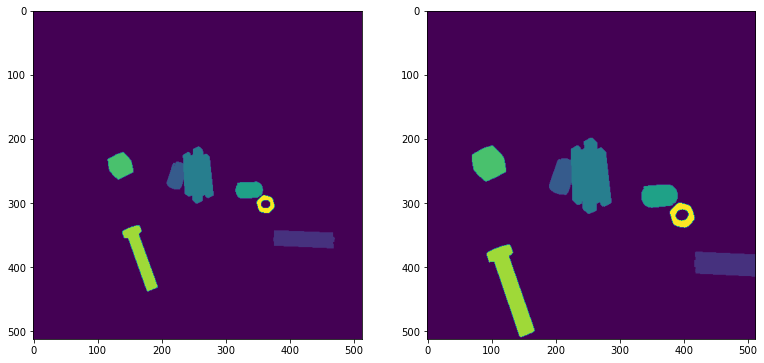

In [524]:
depth = batch['depth0'][0].detach().numpy()

mask0 = batch['mask0'][0].detach().numpy()
mask0 = np.transpose(mask0,(1,2,0))

mask1 = batch['mask1'][0].detach().numpy()
mask1 = np.transpose(mask1,(1,2,0))

plt.figure(figsize=(20, 10))
ax = plt.subplot(1, 3, 1)
plt.imshow(mask0)
ax = plt.subplot(1, 3, 2)
plt.imshow(mask1)

plt.show()

In [525]:
import skimage


In [526]:
K = train_dataset.K
Kinv = train_dataset.Kinv

R = batch['rotation_old_to_new_camera_frame'][0].detach().numpy()
T = batch['translation_old_to_new_camera_frame'][0].detach().numpy()
T

array([[-0.00231364],
       [ 0.00055231],
       [-0.21882915]])

First part
float32 float64
True
second _part 
float32 float64
True
Addition
float32 float64
chcking addition with numpy :  True
checking tensor :  True
checking nupy with tensor :  True
checking adfter div new tensor :  True
int64 int64
checking after clamping :  False
 new pt shape  (3, 262144)
dst  (512, 512, 1)
old_seg  (512, 512, 1)


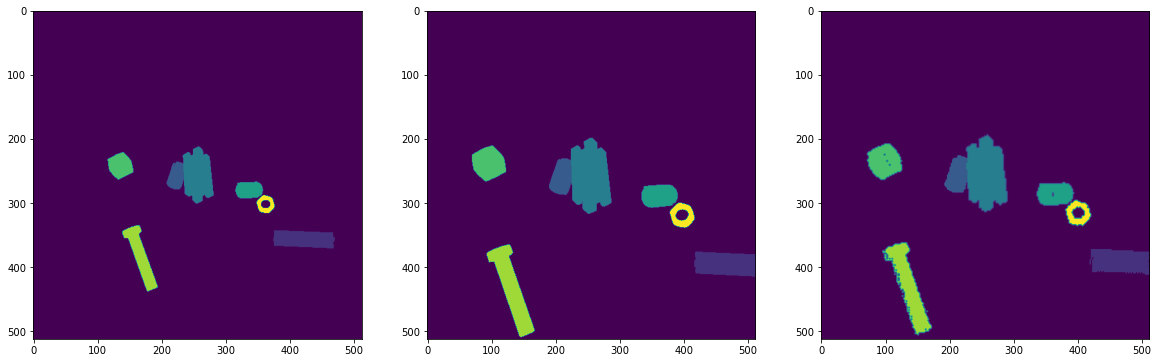

In [531]:
def give_rotation_translation(old_pose, new_pose):
    tm = TransformManager()
    tm.add_transform("world", "old_pose", old_pose)
    tm.add_transform("world", "new_pose", new_pose)
    new2old = tm.get_transform("old_pose", "new_pose")
    return new2old

height, width = depth.shape

K = np.array(K).reshape(3,3)



x = np.arange(height)
y = np.arange(width)

# full coorindate arrays
xx, yy = np.meshgrid(x, y, indexing='ij')
xx = xx.reshape(height*width)
yy = yy.reshape(height*width)

## Stacking to make the matrix 3 x points
pts = np.vstack((xx, yy, np.ones_like(xx)))

ravelFilledDepth = depth.reshape(height*width)

print ("First part")
print (first_part[0].detach().numpy().dtype, K.dot(R).dot(Kinv).dot(pts).dtype)
print (np.allclose(first_part[0].detach().numpy(), K.dot(R).dot(Kinv).dot(pts)))

print ("second _part ")
print (second_part[0].detach().numpy().dtype, K.dot(T/ravelFilledDepth).dtype)
print (np.allclose(second_part[0].detach().numpy(), K.dot(T/ravelFilledDepth)))

print ("Addition")
addd = first_part[0].detach().numpy() + second_part[0].detach().numpy()
new_pt = K.dot(R).dot(Kinv).dot(pts) + K.dot(T/ravelFilledDepth)
print (addd.dtype, new_pt.dtype)
print ("chcking addition with numpy : ", np.allclose(addd[0], new_pt[0], rtol=1e-02))
print ("checking tensor : ", np.allclose(ggg[0].detach().numpy(), new_pt, rtol=1e-02))
print ("checking nupy with tensor : ", np.allclose(ggg[0].detach().numpy(), addd))
new_pt = new_pt / new_pt[2][:]
print ("checking adfter div new tensor : ", np.allclose(new_pts_tensor[0].detach().numpy(), new_pt, rtol=1e-02))
new_pt = new_pt.round().astype(int)
new_pt = new_pt.clip(min=0, max=511)
print (new_pts_tensor_clamped[0].detach().numpy().dtype, new_pt.dtype)
print ("checking after clamping : ", np.allclose(new_pts_tensor_clamped[0].detach().numpy(), new_pt, rtol=1e-01))

print (" new pt shape ", new_pt.shape)
dst = np.zeros_like(mask0)
print ("dst ", dst.shape )
print ("old_seg ", mask0.shape )

dst[new_pt[0], new_pt[1], :] = mask0[xx, yy, : ]

#np.take(mask0, 0, new_pt[0,:].reshape(512,512,1).astype(int))

for i in range(mask0.shape[-1]):
    temp_dst = skimage.measure.block_reduce(dst[:,:,i], (2,2), np.max)
    dst[:,:,i] = skimage.transform.resize(temp_dst, (height,width),
                       anti_aliasing=False)
    #dst[:,:,i] = skimage.transform.rescale( temp_dst, 2)
    
dst = dst.round().astype(int)



plt.figure(figsize=(20, 10))
ax = plt.subplot(1, 3, 1)
plt.imshow(mask0)
ax = plt.subplot(1, 3, 2)
plt.imshow(mask1)
ax = plt.subplot(1, 3, 3)
plt.imshow(dst)
plt.show()


In [540]:
tttt = new_pts_tensor_clamped[0].detach().numpy()
for i in np.arange(50000, 200000, 10):
    if not (np.allclose(new_pt[0][i:i+10], tttt[0][i:i+10])): 
        print (new_pt[0][i:i+10], tttt[0][i:i+10])

[53 53 53 53 53 52 52 52 52 52] [52 52 52 52 52 52 52 52 52 52]
[52 52 52 52 52 52 52 52 52 52] [52 52 51 51 51 51 51 51 51 51]
[52 52 52 52 52 52 52 52 52 52] [51 51 51 51 51 51 51 51 51 51]
[52 52 52 52 52 52 52 52 51 51] [51 51 51 51 51 51 51 51 51 51]
[51 51 51 51 51 51 51 51 51 51] [51 51 51 51 50 50 50 50 50 50]
[51 51 51 51 51 51 51 51 51 51] [50 50 50 50 50 50 50 50 50 50]
[51 51 51 51 51 51 51 51 51 51] [50 50 50 50 50 50 50 50 50 50]
[50 50 50 50 50 50 50 50 50 50] [50 50 50 50 50 50 49 49 49 49]
[50 50 50 50 50 50 50 50 50 50] [49 49 49 49 49 49 49 49 49 49]
[50 50 50 50 50 50 50 50 50 50] [49 49 49 49 49 49 49 49 49 49]
[50 50 49 49 49 49 49 49 49 49] [49 49 49 49 49 49 49 49 49 49]
[49 49 49 49 49 49 60 60 60 60] [49 49 49 49 49 49 59 59 59 59]
[60 60 60 60 60 60 60 60 60 60] [59 59 59 59 59 59 59 59 59 59]
[60 60 60 60 60 60 60 60 60 60] [59 59 59 59 59 59 59 59 59 59]
[59 59 59 59 59 59 59 59 59 59] [59 59 59 59 59 59 59 59 58 58]
[59 59 59 59 59 59 59 59 59 59] [58 58 5

[88 88 88 88 88 88 88 88 88 88] [87 87 87 87 87 87 87 87 87 87]
[88 88 88 88 88 88 88 88 88 88] [87 87 87 87 87 87 87 87 87 87]
[88 88 88 88 88 88 88 88 88 88] [87 87 87 87 87 87 87 87 87 87]
[88 88 87 87 87 87 87 87 87 87] [87 87 87 87 87 87 87 87 87 87]
[87 87 87 87 87 87 87 87 87 87] [87 87 87 87 87 86 86 86 86 86]
[87 87 87 87 87 87 87 87 87 87] [86 86 86 86 86 86 86 86 86 86]
[87 87 87 87 87 87 87 87 87 87] [86 86 86 86 86 86 86 86 86 86]
[87 87 87 87 87 87 87 86 86 86] [86 86 86 86 86 86 86 86 86 86]
[86 86 86 86 86 86 86 86 86 86] [86 86 86 86 86 86 86 86 86 85]
[86 86 86 86 86 86 86 86 86 86] [85 85 85 85 85 85 85 85 85 85]
[86 86 86 86 86 86 86 86 86 86] [85 85 85 85 85 85 85 85 85 85]
[86 86 86 86 86 86 86 86 86 86] [85 85 85 85 85 85 85 85 85 85]
[85 85 85 85 85 85 85 85 85 85] [85 85 84 84 84 84 84 84 84 84]
[85 85 85 85 85 85 85 85 85 85] [84 84 84 84 84 84 84 84 84 84]
[85 85 85 85 85 85 85 85 85 85] [84 84 84 84 84 84 84 84 84 84]
[85 85 85 84 84 84 84 84 84 84] [84 84 8

[115 115 115 115 115 115 115 115 115 115] [114 114 114 114 114 114 114 114 114 114]
[115 115 115 115 115 115 115 115 115 115] [114 114 114 114 114 114 114 114 114 114]
[115 114 114 114 114 114 114 114 114 114] [114 114 114 114 114 114 114 114 114 114]
[114 114 114 114 114 114 114 114 114 114] [114 114 114 114 114 114 114 114 114 113]
[114 114 114 114 114 114 114 114 114 114] [113 113 113 113 113 113 113 113 113 113]
[114 114 114 114 114 114 114 114 114 114] [113 113 113 113 113 113 113 113 113 113]
[114 114 114 114 114 114 114 114 114 114] [113 113 113 113 113 113 113 113 113 113]
[114 114 114 114 114 114 114 113 113 113] [113 113 113 113 113 113 113 113 113 113]
[113 113 113 113 113 113 113 113 113 113] [113 113 113 113 112 112 112 112 112 112]
[113 113 113 113 113 113 113 113 113 113] [112 112 112 112 112 112 112 112 112 112]
[113 113 113 113 113 113 113 113 113 113] [112 112 112 112 112 112 112 112 112 112]
[113 113 113 113 113 113 113 113 113 113] [112 112 112 112 112 112 112 112 1

[142 142 142 142 142 142 142 142 142 142] [141 141 141 141 141 141 141 141 141 141]
[142 142 142 142 142 142 142 142 142 142] [141 141 141 141 141 141 141 141 141 141]
[142 142 142 142 142 142 142 142 142 142] [141 141 141 141 141 141 141 141 141 141]
[142 142 142 142 142 142 142 142 142 142] [141 141 141 141 141 141 141 141 141 141]
[142 142 142 142 141 141 141 141 141 141] [141 141 141 141 141 141 141 141 141 141]
[141 141 141 141 141 141 141 141 141 141] [141 141 141 141 141 141 141 141 141 140]
[141 141 141 141 141 141 141 141 141 141] [140 140 140 140 140 140 140 140 140 140]
[141 141 141 141 141 141 141 141 141 141] [140 140 140 140 140 140 140 140 140 140]
[141 141 141 141 141 141 141 141 141 141] [140 140 140 140 140 140 140 140 140 140]
[141 141 141 141 141 141 141 141 141 141] [140 140 140 140 140 140 140 140 140 140]
[141 141 141 141 140 140 140 140 140 140] [140 140 140 140 140 140 140 140 140 140]
[140 140 140 140 140 140 140 140 140 140] [140 140 140 140 140 140 140 140 1

[172 172 172 172 172 172 172 172 172 172] [171 171 171 171 171 171 171 171 171 171]
[172 172 172 172 172 172 172 172 172 172] [171 171 171 171 171 171 171 171 171 171]
[172 172 172 172 172 172 172 172 172 172] [171 171 171 171 171 171 171 171 171 171]
[172 172 172 172 172 172 172 172 172 172] [171 171 171 171 171 171 171 171 171 171]
[172 172 172 172 172 172 172 172 172 172] [171 171 171 171 171 171 171 171 171 171]
[172 172 172 172 172 172 172 172 172 172] [171 171 171 171 171 171 171 171 171 171]
[172 171 171 171 171 171 171 171 171 171] [171 171 171 171 171 171 171 171 171 171]
[171 171 171 171 171 171 171 171 171 171] [171 171 170 170 170 170 170 170 170 170]
[171 171 171 171 171 171 171 171 171 171] [170 170 170 170 170 170 170 170 170 170]
[171 171 171 171 171 171 171 171 171 171] [170 170 170 170 170 170 170 170 170 170]
[171 171 171 171 171 171 171 171 171 171] [170 170 170 170 170 170 170 170 170 170]
[171 171 171 171 171 171 171 171 171 171] [170 170 170 170 170 170 170 170 1

[205 205 205 205 205 205 205 205 205 205] [204 204 204 204 204 204 204 204 204 204]
[205 205 205 205 205 205 205 205 205 205] [204 204 204 204 204 204 204 204 204 204]
[205 205 205 205 205 205 205 205 205 205] [204 204 204 204 204 204 204 204 204 204]
[205 205 205 205 205 205 205 205 205 205] [204 204 204 204 204 204 204 204 204 204]
[205 205 205 205 205 205 205 205 205 205] [204 204 204 204 204 204 204 204 204 204]
[205 205 205 205 205 205 205 205 205 205] [204 204 204 204 204 204 204 204 204 204]
[205 205 205 205 205 203 203 203 203 203] [204 204 204 204 204 203 203 203 203 203]
[204 204 204 204 204 204 204 204 204 204] [204 204 204 204 204 204 204 204 203 203]
[204 204 204 204 204 204 204 204 204 204] [203 203 203 203 203 203 203 203 203 203]
[204 204 204 204 204 204 204 204 204 204] [203 203 203 203 203 203 203 203 203 203]
[204 204 204 204 204 204 204 204 204 204] [203 203 203 203 203 203 203 203 203 203]
[204 204 204 204 204 204 204 204 204 204] [203 203 203 203 203 203 203 203 2

[240 240 240 240 240 240 240 240 240 240] [239 239 239 239 239 239 239 239 239 239]
[240 240 240 240 240 240 240 240 239 239] [239 239 239 239 239 239 239 239 239 239]
[239 239 239 239 239 240 240 240 240 240] [239 239 239 239 239 239 239 239 239 239]
[240 240 240 240 240 240 240 240 240 240] [239 239 239 239 239 239 239 239 239 239]
[240 240 240 240 240 240 240 240 240 240] [239 239 239 239 239 239 239 239 239 239]
[240 240 240 240 240 240 240 240 240 240] [239 239 239 239 239 239 239 239 239 239]
[240 240 240 240 240 240 240 240 240 240] [239 239 239 239 239 239 239 239 239 239]
[240 240 240 240 240 240 240 240 240 240] [239 239 239 239 239 239 239 239 239 239]
[240 240 240 240 240 239 239 239 239 239] [239 239 239 239 239 239 239 239 239 239]
[239 239 239 239 239 239 239 239 239 239] [239 239 239 239 239 239 239 239 238 238]
[239 239 239 239 239 239 239 239 239 239] [238 238 238 238 238 238 239 239 239 239]
[239 239 239 239 239 239 239 239 239 239] [239 238 238 238 238 238 238 238 2

[275 275 275 275 275 275 275 275 275 275] [274 274 274 274 274 274 274 274 274 274]
[275 275 275 275 275 275 275 275 275 275] [274 274 274 274 274 274 274 274 274 274]
[275 275 275 275 275 275 275 275 275 275] [274 274 274 274 275 275 275 275 275 275]
[275 275 275 275 275 275 276 276 276 276] [275 275 275 275 275 275 275 275 275 275]
[276 276 276 276 276 276 276 276 276 276] [275 275 275 275 275 275 275 275 275 275]
[276 276 276 276 276 276 276 276 276 276] [275 275 275 275 275 275 275 275 275 275]
[276 276 276 276 276 276 276 276 276 276] [275 275 275 275 275 275 275 275 275 275]
[276 276 276 276 276 276 276 276 276 276] [275 275 275 275 275 275 275 275 275 275]
[276 276 276 276 276 276 276 276 276 276] [275 275 275 275 275 275 275 275 275 275]
[276 276 276 276 276 276 276 276 276 276] [275 275 275 275 275 275 275 275 275 275]
[276 276 276 276 276 276 276 276 276 276] [275 275 275 275 275 275 275 275 275 275]
[276 276 276 276 276 276 276 276 276 276] [275 275 275 275 275 275 275 275 2

[306 306 306 306 305 305 305 306 306 306] [306 306 306 306 305 305 305 305 305 305]
[306 306 306 306 306 306 306 306 306 306] [305 305 305 305 305 305 305 305 305 305]
[306 306 306 306 306 306 306 306 306 306] [305 305 305 305 305 305 305 305 305 305]
[306 306 306 306 306 306 306 306 306 306] [305 305 305 305 305 305 305 305 305 305]
[306 306 306 306 306 306 306 306 306 306] [305 305 305 305 305 305 305 305 305 305]
[306 306 306 306 306 306 306 306 306 306] [305 305 305 305 305 305 305 305 305 305]
[306 306 306 306 306 306 306 306 306 306] [305 305 305 305 305 305 305 305 305 305]
[306 306 306 306 306 306 306 306 306 306] [305 305 305 305 305 305 305 305 305 305]
[306 306 306 306 306 306 306 306 306 306] [305 305 305 305 305 305 305 305 305 305]
[306 306 306 306 306 306 306 307 307 307] [306 306 306 306 306 306 306 306 306 306]
[307 306 306 307 307 307 307 307 307 307] [306 306 306 306 306 306 306 306 306 306]
[307 307 307 306 306 306 306 306 306 306] [306 306 306 306 305 305 305 305 3

[340 340 340 340 340 340 340 340 340 340] [339 339 339 339 339 339 339 339 339 339]
[340 340 340 340 340 340 340 340 340 340] [339 339 339 339 339 339 339 340 340 340]
[340 340 340 340 340 340 341 341 341 341] [340 340 340 340 340 340 340 340 340 340]
[341 341 341 341 341 341 341 341 341 341] [340 340 340 340 340 340 340 340 340 340]
[341 341 341 341 341 341 341 341 341 341] [340 340 340 340 340 340 340 340 340 340]
[341 341 341 341 341 341 341 341 341 341] [340 340 340 340 340 340 340 340 340 340]
[341 341 341 341 341 341 341 341 341 341] [340 340 340 340 340 340 340 340 340 340]
[341 341 341 341 341 341 341 341 341 341] [340 340 340 340 340 340 340 340 340 340]
[341 341 341 341 341 341 341 341 341 341] [340 340 340 340 340 340 340 340 340 340]
[341 341 341 341 341 341 341 341 341 341] [340 340 340 340 341 341 341 341 341 341]
[341 342 342 342 342 342 342 342 342 342] [341 341 341 341 341 341 341 341 341 341]
[342 342 342 342 342 342 342 342 342 342] [341 341 341 341 341 341 341 341 3

[371 371 371 371 371 371 371 371 371 372] [371 371 371 371 371 371 371 371 371 371]
[372 372 372 372 372 372 372 372 372 372] [371 371 371 371 371 371 371 371 371 371]
[372 372 372 372 372 372 372 372 372 372] [371 371 371 371 371 371 371 371 371 371]
[372 372 372 372 372 372 372 372 372 372] [371 371 371 371 371 371 371 371 371 371]
[372 372 372 372 372 372 372 372 372 372] [371 371 371 371 371 371 371 371 371 371]
[372 372 372 372 372 372 372 372 372 372] [371 371 371 371 371 371 371 371 372 372]
[372 372 372 372 372 372 372 372 372 376] [372 372 372 372 372 372 372 372 372 375]
[376 376 376 376 376 376 376 376 376 376] [375 376 376 376 376 376 376 376 376 376]
[376 376 376 376 376 376 376 375 372 372] [376 376 376 375 375 375 375 375 372 372]
[372 372 372 372 372 372 372 373 373 373] [372 372 372 372 372 372 372 372 372 372]
[373 373 373 373 373 373 373 373 373 373] [372 372 372 372 372 372 372 372 372 372]
[373 373 373 373 373 373 373 373 373 373] [372 372 372 372 372 372 372 372 3

[404 404 404 404 404 404 404 404 404 404] [403 403 403 403 403 403 403 403 403 403]
[404 404 404 404 404 404 404 404 404 404] [403 403 403 403 403 403 403 403 403 403]
[404 404 404 404 404 404 404 404 404 404] [403 403 403 403 403 403 403 403 403 403]
[404 404 404 404 404 404 404 406 406 406] [403 403 403 403 403 403 403 405 405 405]
[406 406 406 406 406 406 406 406 406 406] [405 405 405 405 405 405 405 405 405 405]
[406 406 406 406 406 406 406 406 406 406] [405 405 405 405 405 405 405 405 405 405]
[406 406 406 406 406 406 406 406 406 406] [405 405 405 405 405 405 405 405 405 405]
[406 406 406 406 406 406 406 406 406 406] [405 405 405 405 405 405 406 406 406 406]
[405 405 405 405 405 405 406 406 406 406] [405 405 405 405 405 405 405 405 405 405]
[406 406 406 406 406 406 406 406 406 406] [405 405 405 405 405 405 405 405 405 405]
[406 406 406 406 406 406 406 406 406 406] [405 405 405 405 405 405 405 405 405 405]
[406 406 406 406 400 400 400 400 400 400] [405 405 405 405 400 400 400 400 4

In [529]:
new_pts_tensor_clamped[0].detach().numpy().dtype

dtype('int64')

Comparing 

In [481]:
new_pts_tensor[0].detach().numpy()

array([[  0,   0,   0, ..., 511, 511, 511],
       [  0,   0,   0, ..., 511, 511, 511],
       [  1,   1,   1, ...,   1,   1,   1]])

In [483]:
new_pt

array([[  0,   0,   0, ..., 511, 511, 511],
       [  0,   0,   0, ..., 511, 511, 511],
       [  1,   1,   1, ...,   1,   1,   1]])

In [517]:
np.allclose(new_pts_tensor[0].detach().numpy(), new_pt, rtol=1e-02)

False

-----

In [348]:
np.unique(mask)

array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32)

In [354]:
dst

array([[[0],
        [0],
        [1],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [1],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [1],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [1],
        ...,
        [1],
        [0],
        [0]],

       [[0],
        [0],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[0],
        [0],
        [1],
        ...,
        [1],
        [1],
        [1]]])

In [342]:
mask1.dtype

dtype('float32')